In [1]:
# TODO: add crop for log_sigma and for abs diff for FVC
# TODO: add normalization for data
# TODO: ...

In [2]:
%config Completer.use_jedi = False

import os
import platform
from collections import namedtuple
import time

from tqdm.notebook import tqdm
import tabulate

import pandas as pd
import numpy as np
import sparse

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.loss import _Loss
from torch.optim.lr_scheduler import _LRScheduler
# from torchvision import transforms
# from torchsummary import summary
# from efficientnet_pytorch_3d import EfficientNet3D
from my_efficientnet_pytorch_3d import EfficientNet3D
import torchio

from utils import CTDataset


########################

RUNNING_IN_KAGGLE = 'linux' in platform.platform().lower()
IMAGE_PATH = "../input/osic-pulmonary-fibrosis-progression/" if RUNNING_IN_KAGGLE else 'data/'
PROCESSED_PATH = 'FIX IT!' if RUNNING_IN_KAGGLE else 'data/processed-data/'  # TODO: fix this line

dtype = torch.float32
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
device = torch.device(device)

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [3]:
class SqueezeLayer(nn.Module):
    def forward(self, x):
        return x.squeeze()


class FeatureExtractor(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def forward(self, x):
        return self.net.extract_features(x.unsqueeze(0).unsqueeze(0))

In [4]:
class VGG(torch.nn.Module):
    _vgg_configurations = {
        'small': [8, 'M', 8, 'M', 16, 'M', 16, 'M'],  # , 64, 'M', 64, 'M'],  # , 512, 'M', 512, 'M'],
        8: [64, 'M', 128, 'M', 256, 'M', 512, 'M', 512, 'M'],
        11: [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        13: [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        16: [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
        19: [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    }

    @staticmethod
    def _make_layers(cfg, batch_norm):
        layers = []
        in_channels = 1
        for v in cfg:
            if v == 'M':
                layers += [torch.nn.MaxPool3d(kernel_size=2, stride=2)]
            else:
                layers += [torch.nn.Conv3d(in_channels, v, kernel_size=3, padding=1)]
                if batch_norm:
                    layers += [torch.nn.BatchNorm3d(v)]
                layers += [torch.nn.ReLU(inplace=True)]
                in_channels = v
        return layers

    def __init__(self, VGG_version, batch_norm):  # num_classes, 
        super().__init__()
        self.VGG_version = VGG_version
        self.batch_norm = batch_norm
#         self.num_classes = num_classes

#         self.layers = torch.nn.ModuleList([
#             # Convolution Layers
#             *make_layers(_vgg_configurations[VGG_version], batch_norm),

#             torch.nn.modules.flatten.Flatten(),

#             # Fully Connected Layers
#             torch.nn.Dropout(),
#             torch.nn.Linear(512, 512),
#             torch.nn.ReLU(inplace=True),
#             torch.nn.Dropout(),
#             torch.nn.Linear(512, 512),
#             torch.nn.ReLU(inplace=True),
#             torch.nn.Linear(512, num_classes),
#         ])
        
        self.net = nn.Sequential(
            *VGG._make_layers(self._vgg_configurations[VGG_version], batch_norm)
        )

        self._initialize_weights()

    def _initialize_weights(self):
#         for module in self.modules():
#             if isinstance(module, torch.nn.Conv3d):
#                 torch.nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
#                 if module.bias is not None:
#                     torch.nn.init.constant_(module.bias, 0)
        for m in self.modules():
            if isinstance(m, torch.nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, torch.nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor):  # , target_layers: Optional[set] = None):
#         intermediate_layers = []
#         for idx, layer in enumerate(self.layers):
#             if target_layers is not None and idx in target_layers:
#                 x.requires_grad_(True)
#                 intermediate_layers.append(x)
#             x = layer(x)
#         if target_layers is not None and len(self.layers) in target_layers:
#             x.requires_grad_(True)
#             intermediate_layers.append(x)

#         if target_layers is not None:
#             return x, intermediate_layers
        return self.net(x)

In [5]:
class LaplaceLoss(nn.Module):  # _Loss):
    def forward(self, y_true, preds, log_sigma, metric=False):
        abs_diff = (y_true - preds).abs()

        log_sigma.clamp_(-5, 5)

        if metric:
            abs_diff.clamp_max_(1000)
            log_sigma.clamp_(-np.log(70), np.log(70))  # TODO: min bound is strange??

#         log_sigma.clamp_min_(-5)

        losses = np.sqrt(2) * abs_diff / log_sigma.exp() + log_sigma + np.log(2) / 2
        return losses.mean()

In [23]:
class OSICNet(nn.Module):
    def __init__(self, dtype, device, efficient_net_model_number, hidden_size, dropout_rate):  # , output_size
        super().__init__()

        self.dtype = dtype
        self.device = device

        self.CT_features_extractor = nn.Sequential(
#             FeatureExtractor(
#                 EfficientNet3D.from_name(
#                     f'efficientnet-b{efficient_net_model_number}', override_params={'num_classes': 1}, in_channels=1
#                 )
#             ),
            VGG('small', True),
            nn.AdaptiveAvgPool3d(1),
            SqueezeLayer()
        )

        self.predictor = nn.Sequential(
            nn.Linear(16 + 4, hidden_size),  # 16 +   # 1294
            nn.ReLU(),  # nn.Tanh(),  # 
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),  # nn.Tanh(),  # 
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 2)  # FVC & log_sigma  # output_size
        )

        self._initialize_weights()

        self.CT_features_extractor.to(self.device)
        self.predictor.to(self.device)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, torch.nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        
#     def forward(self, data):
#         mean_dataset, std_dataset = -971.4692260919278, 117.84143467421829
#         lungs = -1000 * (1.0 - data.masks) + data.masks * data.images
#         lungs = (lungs - mean_dataset) / std_dataset
#         lungs = torch.tensor(lungs, dtype=self.dtype, device=self.device)
#         lungs_features = self.CT_features_extractor(lungs)

#         data_weeks = torch.tensor(data.weeks, dtype=self.dtype)
#         weeks = torch.empty(len(data.weeks), 4, dtype=self.dtype)
#         weeks[:, 3] = 1
#         weeks[:, 2] = data_weeks
#         weeks[:, 1] = data_weeks ** 2
#         weeks[:, 0] = data_weeks ** 3

#         agg_loss = 0
#         for week, FVC in zip(data.weeks, data.fvcs):
#             table_features = torch.tensor(np.r_[week, FVC, data.features], dtype=self.dtype, device=self.device)
#             X = lungs_features  # torch.cat([lungs_features, table_features])

#             pred_numbers = self.predictor(X).cpu()
#             coefs = pred_numbers[:4]
#             log_sigma = pred_numbers[4]

#             FVC_preds = (weeks * coefs).sum(dim=1)
#             FVC_true = torch.tensor(data.fvcs, dtype=self.dtype)

#             agg_loss += LaplaceLoss()(FVC_true, FVC_preds, log_sigma)

#         return agg_loss / len(data.weeks)

    def _normalize_data(self, data):
        percents, weeks, FVCs, features, masks, images = data

        lungs_mean, lungs_std = -971.4692260919278, 117.84143467421829
        lungs = -1000 * (1.0 - masks) + masks * images
        lungs = (lungs - lungs_mean) / lungs_std
#         lungs = lungs.type(self.dtype)
#         lungs = torch.tensor(lungs, dtype=self.dtype, device=self.device)
#         lungs_features = self.CT_features_extractor(lungs)

        percents_mean, percents_std = 77.6726, 19.8233
        weeks_mean, weeks_std = 31.861846352485475, 23.240045178171002
        FVCs_mean, FVCs_std = 2690.479018721756, 832.5021066817238
#         other_ftrs_mean = np.array([
#             2.76561876e+00,  1.42373805e+00,  1.25608294e+00,  1.33766080e+02,
#             -5.23857955e+02, -1.24154545e+03,  6.72613636e+01,  7.89772727e-01,
#             2.10227273e-01,  6.70454545e-01,  2.78409091e-01,  5.11363636e-02
#         ])
#         other_ftrs_std = np.array([
#             2.34777445e+00, 1.47563586e-01, 9.90841780e-01, 5.85989667e+01,
#             1.92059435e+02, 8.48268563e+02, 7.06784382e+00, 4.07469958e-01,
#             4.07469958e-01, 4.70048134e-01, 4.48215873e-01, 2.20275818e-01
#         ])

        percents = (percents - percents_mean) / percents_std
        weeks = (weeks - weeks_mean) / weeks_std
        FVCs = (FVCs - FVCs_mean) / FVCs_std
#         features = (features - other_ftrs_mean) / other_ftrs_std
        features = features.type(self.dtype)
#         masks = lungs
#         images = None

        return percents, weeks, FVCs, features, lungs, images

    def forward(self, data):
        percents, weeks, FVCs, features, lungs, images = self._normalize_data(data)

        ###############################
        lungs = lungs.to(dtype=self.dtype, device=self.device)
        lungs = lungs.unsqueeze(0)  # .to(self.device)  # TODO: uncomment
        lungs_features = self.CT_features_extractor(lungs)
        ###############################

#         weeks_mean, weeks_std = 31.861846352485475, 23.240045178171002
#         FVCs_mean, FVCs_std = 2690.479018721756, 832.5021066817238
#         other_ftrs_mean = np.array([
#             2.76561876e+00,  1.42373805e+00,  1.25608294e+00,  1.33766080e+02,
#             -5.23857955e+02, -1.24154545e+03,  6.72613636e+01,  7.89772727e-01,
#             2.10227273e-01,  6.70454545e-01,  2.78409091e-01,  5.11363636e-02
#         ])
#         other_ftrs_std = np.array([
#             2.34777445e+00, 1.47563586e-01, 9.90841780e-01, 5.85989667e+01,
#             1.92059435e+02, 8.48268563e+02, 7.06784382e+00, 4.07469958e-01,
#             4.07469958e-01, 4.70048134e-01, 4.48215873e-01, 2.20275818e-01
#         ])

#         data._replace(weeks = (np.array(data.weeks) - weeks_mean) / weeks_std)
#         data._replace(fvcs = (np.array(data.fvcs) - FVCs_mean) / FVCs_std)
#         data._replace(features = (np.array(data.features) - other_ftrs_mean) / other_ftrs_std)

#         data_weeks = torch.tensor(data.weeks, dtype=self.dtype)
#         weeks = torch.empty(len(data.weeks), 4, dtype=self.dtype)
#         weeks[:, 3] = 1
#         weeks[:, 2] = data_weeks
#         weeks[:, 1] = data_weeks ** 2
#         weeks[:, 0] = data_weeks ** 3

#         agg_loss = 0
        all_preds = []
        for base_percent, base_week, base_FVC in zip(percents, weeks, FVCs):
            table_features = torch.cat([
                torch.tensor([base_percent]),
                torch.tensor([base_week]),
                torch.tensor([base_FVC]),
#                 features
            ]).to(self.device)  # torch.tensor([week]),

            all_features = torch.cat([lungs_features, table_features])  # lungs_features,  # TODO: uncomment

            X = torch.cat([all_features.repeat(weeks.shape[0], 1), weeks.unsqueeze(1).to(self.device)], dim=1)

            preds = self.predictor(X).cpu()
            
#             for week in weeks:
#                 table_features = torch.cat([torch.tensor([base_week]), torch.tensor([base_FVC]),
#                                             torch.tensor([week]), features]).to(self.device)
# #                                            dtype=self.dtype, device=self.device)
#                 X = torch.cat([lungs_features, table_features])  # .to(self.device)  # lungs_features

#                 pred_numbers = self.predictor(X).cpu()
#                 preds = self.predictor(X).cpu()
            all_preds.append(preds)
#             coefs = pred_numbers[:4]
#             log_sigma = pred_numbers[4]

#             FVC_preds = (weeks * coefs).sum(dim=1)
#             FVC_true = torch.tensor(data.fvcs, dtype=self.dtype)
            
#             agg_loss += LaplaceLoss()(FVC_true, FVC_preds, log_sigma)

#         return agg_loss / len(data.weeks)
        return all_preds

#     def forward(self, data):
#         lungs_mean, lungs_std = -971.4692260919278, 117.84143467421829
#         lungs = -1000 * (1.0 - data.masks) + data.masks * data.images
#         lungs = (lungs - lungs_mean) / lungs_std
#         lungs = torch.tensor(lungs, dtype=self.dtype, device=self.device)
#         lungs_features = self.CT_features_extractor(lungs)

#         weeks_mean, weeks_std = 31.861846352485475, 23.240045178171002
#         FVCs_mean, FVCs_std = 2690.479018721756, 832.5021066817238
#         other_ftrs_mean = np.array([
#             2.76561876e+00,  1.42373805e+00,  1.25608294e+00,  1.33766080e+02,
#             -5.23857955e+02, -1.24154545e+03,  6.72613636e+01,  7.89772727e-01,
#             2.10227273e-01,  6.70454545e-01,  2.78409091e-01,  5.11363636e-02
#         ])
#         other_ftrs_std = np.array([
#             2.34777445e+00, 1.47563586e-01, 9.90841780e-01, 5.85989667e+01,
#             1.92059435e+02, 8.48268563e+02, 7.06784382e+00, 4.07469958e-01,
#             4.07469958e-01, 4.70048134e-01, 4.48215873e-01, 2.20275818e-01
#         ])

#         data._replace(weeks = (np.array(data.weeks) - weeks_mean) / weeks_std)
#         data._replace(fvcs = (np.array(data.fvcs) - FVCs_mean) / FVCs_std)
#         data._replace(features = (np.array(data.features) - other_ftrs_mean) / other_ftrs_std)

# #         data_weeks = torch.tensor(data.weeks, dtype=self.dtype)
# #         weeks = torch.empty(len(data.weeks), 4, dtype=self.dtype)
# #         weeks[:, 3] = 1
# #         weeks[:, 2] = data_weeks
# #         weeks[:, 1] = data_weeks ** 2
# #         weeks[:, 0] = data_weeks ** 3

# #         agg_loss = 0
#         all_preds = []
#         for week, FVC in zip(data.weeks, data.fvcs):
#             table_features = torch.tensor(np.r_[week, FVC, data.features], dtype=self.dtype, device=self.device)
#             X = torch.cat([lungs_features, table_features])  # lungs_features

#             pred_numbers = self.predictor(X).cpu()
#             all_preds.append(pred_numbers)
# #             coefs = pred_numbers[:4]
# #             log_sigma = pred_numbers[4]

# #             FVC_preds = (weeks * coefs).sum(dim=1)
# #             FVC_true = torch.tensor(data.fvcs, dtype=self.dtype)
            
# #             agg_loss += LaplaceLoss()(FVC_true, FVC_preds, log_sigma)

# #         return agg_loss / len(data.weeks)
#         return all_preds


class LinearDecayLR(_LRScheduler):
    def __init__(self, optimizer, start_epoch, stop_epoch, start_lr, stop_lr, last_epoch=-1):
        self.optimizer = optimizer

        self.start_epoch = start_epoch
        self.stop_epoch = stop_epoch

        self.start_lr = start_lr
        self.stop_lr = stop_lr

        self.last_epoch = last_epoch

        super().__init__(optimizer, last_epoch)

    def get_lr(self) -> list:
        if self.last_epoch < self.start_epoch:
            new_lr = self.start_lr
        elif self.last_epoch > self.stop_epoch:
            new_lr = self.stop_lr
        else:
            new_lr = self.start_lr + (
                (self.stop_lr - self.start_lr) *
                (self.last_epoch - self.start_epoch) /
                (self.stop_epoch - self.start_epoch)
            )
        return [new_lr for _ in self.optimizer.param_groups]

In [24]:
transforms = torchio.transforms.Compose([
    torchio.transforms.RandomAffine(
        degrees=(10, 10),
        translation=(-10, -10),
        isotropic=False,
        default_pad_value='minimum',
        image_interpolation='linear',
    ),
#     torchio.transforms.RandomElasticDeformation(
#         max_displacement=3.0
#     )
])

In [25]:
train_dataset = CTDataset(
    f'{PROCESSED_PATH}/train',
    f'{IMAGE_PATH}/train.csv',
    train=True,
    transform=transforms,
    test_size=0.25,
    padding_mode='edge',
    random_state=42,
    pad_global=False,
)

test_dataset = CTDataset(
    f'{PROCESSED_PATH}/train',
    f'{IMAGE_PATH}/train.csv',
    train=False,
    transform=transforms,
    test_size=0.25,
    padding_mode='edge',
    random_state=42,
    pad_global=False,
)

In [26]:
# dl = DataLoader(train_dataset, batch_size=1, num_workers=4)
# # next(iter(dl))

# from tqdm.notebook import tqdm

# # %%time

# # for _ in tqdm(dl):
# #     pass

# # %%time

# # for _ in train_dataset:
# #     pass

# # # _

In [27]:
model = OSICNet(dtype=dtype, device=device, efficient_net_model_number=0, hidden_size=100, dropout_rate=0)  # 512, 0.5)
# optimizer = optim.SGD(model.parameters(), lr=1e-8, momentum=0.9)  # , weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # 3e-4
# optimizer = optim.SGD(model.parameters(), lr=1e-3)  # 3e-4


### TMP ###
# optimizer = optim.SGD(model.parameters(), lr=1e-9, momentum=0, weight_decay=0)  # 0.9, 5e-4)
# lr_scheduler = LinearDecayLR(optimizer, )



# for g in optimizer.param_groups:
#     g['lr'] /= 10



# from torchsummary import summary
# summary(model.CT_features_extractor[0].net)

# mmm = FeatureExtractor(
#     EfficientNet3D.from_name(
#         f'efficientnet-b{0}', override_params={'num_classes': 1}, in_channels=1
#     )
# )

# summary(mmm)

# preds = model(train_dataset[0])
# preds


# torch.cat([torch.tensor([1]), torch.tensor([2]), torch.tensor([3]), torch.tensor([1, 2, 3])])

# lungs_features.shape

# preds
# preds[0]

In [28]:
from torch.utils.tensorboard import SummaryWriter

log_writer = SummaryWriter(log_dir='logs/CT_features/')

In [29]:
def print_results(writer, epoch, cur_iter, loss, metric, metric_last_3, start_time,
                  cur_start_time, cur_end_time, log_sigmas):
    writer.add_scalar('loss', loss.item(), epoch)
    writer.add_scalar('metric', metric, epoch)
    writer.add_scalar('metric (last 3)', metric_last_3, epoch)
    writer.add_scalar('log sigma', log_sigmas.detach().mean().item(), epoch)
    
    columns = [
        'Epoch', 
        'Iter', 
        'Loss', 
        'Metric', 
        'Metric (last 3)', 
        'Cur iter time', 
        'Elapsed time', 
        'Log sigma'
    ]

    values = [
        f'{epoch + 1}',
        f'{cur_iter + 1}',
        f'{loss.item():0.6f}',
        f'{metric:0.6f}',
        f'{metric_last_3:0.6f}',
        f'{cur_end_time - cur_start_time:0.1f} sec',
        f'{cur_end_time - start_time:0.1f} sec',
        f'{log_sigmas.detach().mean().item():0.3f}'
    ]
    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='8.4f')
    if cur_iter % 40 == 0:
        table = table.split('\n')
        table = '\n'.join([table[1]] + table)
    else:
        table = table.split('\n')[2]
    print(table)

In [32]:
MAX_EPOCHS = 10


start_time = time.time()
for epoch in tqdm(range(MAX_EPOCHS)):
    for cur_iter, data in enumerate(train_dataset):  # tqdm(, desc='Iteration over dataset'):
#         if cur_iter >= 1:
#             break
        cur_start_time = time.time()

        optimizer.zero_grad()

#         loss = model(data)
        percents, weeks, FVC_true, features, lungs, images = data
        FVCs_mean, FVCs_std = 2690.479018721756, 832.5021066817238

        all_preds = model(data)

        agg_loss = 0
        agg_metric = 0
        agg_metric_last_3 = 0
        for preds in all_preds:  # zip(, [None, ]):  # TODO: REMOVE!
            FVC_preds, log_sigmas = preds.transpose(0, 1)
            FVC_preds = FVC_preds * FVCs_std + FVCs_mean

            agg_loss += LaplaceLoss()(FVC_true, FVC_preds, log_sigmas)
#             agg_loss += nn.MSELoss()(FVC_true, FVC_preds).pow(0.5)  # , log_sigmas)
            with torch.no_grad():
                agg_metric += LaplaceLoss()(FVC_true, FVC_preds, torch.tensor(5.), metric=True).item()  # log_sigmas
                agg_metric_last_3 += LaplaceLoss()(FVC_true[-3:], FVC_preds[-3:], torch.tensor(5.), metric=True).item()
        loss = agg_loss / weeks.shape[0]
        metric = agg_metric / weeks.shape[0]
        metric_last_3 = agg_metric_last_3 / weeks.shape[0]

        loss.backward()
        optimizer.step()

        cur_end_time = time.time()

        print_results(log_writer, epoch, cur_iter, loss, metric, metric_last_3,
                      start_time, cur_start_time, cur_end_time, log_sigmas)

#         print(
#             f'Epoch {epoch + 1:3d}, '
#             f'iter {cur_iter + 1:4d}, '
#             f'loss {loss.item():12.6f}, '
#             f'metric {metric:12.6f}, '
#             f'metric (last 3) {metric_last_3:12.6f}, '
#             f'cur iter time {cur_end_time - cur_start_time:6.1f} sec, '
#             f'elapsed time {cur_end_time - start_time:6.1f} sec, '
#             f'log sigma {log_sigmas.detach().mean().item()}'
#         )

-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      Log sigma
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
      1       1    9.5931   14.8240            16.5052  0.3 sec          1.6 sec              5.0000
      1       2    7.5358   10.4622            10.3931  0.3 sec          3.1 sec              5.0000
      1       3   11.5412   18.7511            19.4223  0.3 sec          4.6 sec              5.0000
      1       4    9.0299   13.6300            14.2126  0.3 sec          6.0 sec              5.0000
      1       5    8.7546   13.0463            13.4227  0.3 sec          7.5 sec              5.0000
      1       6   13.7582   20.2894            20.2894  0.3 sec          9.1 sec              5.0000
      1       7    5.3495    5.8269             6.8870  0.2 sec          10.7 sec          

      1      77    5.8934    6.9800             5.3111  0.3 sec          103.5 sec            5.0000
      1      78    8.8179   13.1804            13.2985  0.3 sec          104.9 sec            5.0000
      1      79    7.5025   10.6639            11.6907  0.3 sec          106.3 sec            5.0000
      1      80   10.4028   16.5406            18.5834  0.3 sec          107.6 sec            5.0000
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      Log sigma
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
      1      81    5.0811    5.2579             5.4649  0.3 sec          108.9 sec            5.0000
      1      82    9.1990   13.9885            14.0535  0.3 sec          110.2 sec            5.0000
      1      83    7.1502    9.6446             9.5076  0.3 sec          111.5 sec         

      2      18   17.0295   19.8385            19.8385  0.2 sec          206.1 sec            5.0000
      2      19    5.0724    5.2393             4.8852  0.3 sec          207.4 sec            5.0000
      2      20   13.8299   20.2894            20.2894  0.3 sec          208.6 sec            5.0000
      2      21    5.2837    5.6873             4.2881  0.3 sec          209.9 sec            5.0000
      2      22    5.8155    6.9374             7.0113  0.3 sec          211.2 sec            5.0000
      2      23    7.6856   10.7798            11.0973  0.3 sec          212.5 sec            5.0000
      2      24   13.9012   20.6651            20.6651  0.3 sec          213.8 sec            5.0000
      2      25    9.1644   13.9151            12.7062  0.3 sec          215.1 sec            5.0000
      2      26   11.9313   19.1898            19.4520  0.3 sec          216.4 sec            4.9950
      2      27    6.6349    8.5522            10.6417  0.3 sec          217.7 sec         

      2      94   13.7375   17.7940            15.7095  0.3 sec          305.0 sec            5.0000
      2      95   11.0585   17.5666            17.2561  0.3 sec          306.3 sec            5.0000
      2      96    6.3731    7.9970             5.8994  0.3 sec          307.7 sec            5.0000
      2      97    6.6983    8.6865             9.9505  0.3 sec          309.0 sec            5.0000
      2      98    5.0856    5.2673             4.8029  0.3 sec          310.3 sec            5.0000
      2      99    9.7579   15.2961            15.2074  0.3 sec          311.7 sec            5.0000
      2     100   11.5198   18.2360            17.9566  0.3 sec          313.0 sec            5.0000
      2     101   13.2233   20.2882            20.2894  0.3 sec          314.4 sec            5.0000
      2     102    7.8600   11.1496            10.5790  0.3 sec          315.9 sec            5.0000
      2     103   15.1940   20.2894            20.2894  0.3 sec          317.2 sec         

      3      38    5.3791    5.8896             5.1763  0.3 sec          405.3 sec            5.0000
      3      39    7.3853   10.2307            14.0356  0.3 sec          406.5 sec            5.0000
      3      40    7.5308   10.3380             8.8899  0.3 sec          407.9 sec            5.0000
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      Log sigma
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
      3      41    5.4290    5.9953             6.0108  0.2 sec          409.3 sec            5.0000
      3      42    9.1554   14.0185            12.1021  0.3 sec          410.5 sec            5.0000
      3      43   12.9078   17.9996            16.0913  0.2 sec          411.8 sec            5.0000
      3      44    5.8327    6.9740             8.2010  0.2 sec          413.1 sec         

      3     114    7.1453    9.6343             8.3560  0.3 sec          501.9 sec            5.0000
      3     115   10.8981   17.3980            14.2915  0.2 sec          503.2 sec            5.0000
      3     116   10.2013   16.1136            13.6786  0.3 sec          504.5 sec            5.0000
      3     117    6.7467    8.7891            10.3108  0.3 sec          505.8 sec            5.0000
      3     118    8.4782   12.4378            16.1810  0.3 sec          507.0 sec            5.0000
      3     119   15.2841   20.2894            20.2894  0.3 sec          508.2 sec            4.9910
      3     120    9.1145   13.8094            12.9358  0.2 sec          509.5 sec            5.0000
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      Log sigma
-------  ------  --------  --------  -----------------  ---------------  --------------  --

      4      55   14.4951   20.2894            20.2894  0.3 sec          597.6 sec            5.0000
      4      56    5.0595    5.2121             4.9463  0.3 sec          599.1 sec            5.0000
      4      57   10.5370   16.8254            16.9934  0.3 sec          600.5 sec            5.0000
      4      58    7.4173   10.2111             9.6886  0.3 sec          602.1 sec            5.0000
      4      59    6.4464    8.1524             9.2508  0.3 sec          603.6 sec            5.0000
      4      60    5.8040    6.7904             6.9569  0.3 sec          605.3 sec            5.0000
      4      61   11.7772   18.7770            19.9346  0.3 sec          606.6 sec            5.0000
      4      62    6.1778    7.5829             8.8694  0.3 sec          608.0 sec            5.0000
      4      63   13.7209   20.1142            20.2894  0.3 sec          609.3 sec            5.0000
      4      64    5.8463    6.8802             9.8529  0.3 sec          610.6 sec         

      4     131    5.9192    7.0346             6.0465  0.3 sec          695.8 sec            5.0000
      4     132   10.3552   16.5623            16.9964  0.2 sec          697.1 sec            5.0000
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      Log sigma
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
      5       1    9.0423   13.6563            15.2954  0.3 sec          698.3 sec            5.0000
      5       2    7.8690   11.1687            10.0390  0.2 sec          699.5 sec            5.0000
      5       3   11.0109   17.7883            18.3429  0.3 sec          700.8 sec            5.0000
      5       4    8.4943   12.4944            13.0333  0.3 sec          702.1 sec            5.0000
      5       5    8.2297   11.9335            12.2679  0.2 sec          703.3 sec         

      5      75    7.3504   10.0691            12.9017  0.2 sec          791.2 sec            5.0000
      5      76    5.8301    7.1182             8.5935  0.2 sec          792.5 sec            5.0000
      5      77    6.1772    7.5817             5.8776  0.2 sec          793.8 sec            5.0000
      5      78    9.0879   13.7529            13.8990  0.2 sec          795.1 sec            5.0000
      5      79    7.2019   10.0267            11.0344  0.2 sec          796.3 sec            5.0000
      5      80   10.0652   15.8250            17.8419  0.3 sec          797.6 sec            5.0000
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      Log sigma
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
      5      81    5.1058    5.3102             5.2760  0.2 sec          798.8 sec         

      6      16    8.0658   11.5859             9.7919  0.2 sec          881.7 sec            5.0000
      6      17    5.5792    6.3139             5.9384  0.3 sec          883.1 sec            5.0000
      6      18   16.7794   19.8385            19.8385  0.3 sec          884.3 sec            5.0000
      6      19    5.2969    5.7154             5.3824  0.2 sec          885.6 sec            5.0000
      6      20   13.5755   20.2894            20.2894  0.2 sec          886.8 sec            5.0000
      6      21    5.4380    6.0144             4.4111  0.3 sec          888.1 sec            5.0000
      6      22    5.8578    7.0271             6.8645  0.2 sec          889.3 sec            5.0000
      6      23    7.4713   10.3255            10.6227  0.3 sec          890.6 sec            5.0000
      6      24   13.6400   20.6651            20.6651  0.3 sec          891.8 sec            5.0000
      6      25    9.3466   14.2882            13.0870  0.3 sec          893.1 sec         

      6      92    8.6848   12.8983            11.4411  0.2 sec          976.7 sec            5.0000
      6      93    6.2062    7.7658            10.0658  0.2 sec          977.9 sec            5.0000
      6      94   13.7976   17.8193            15.7619  0.2 sec          979.3 sec            5.0000
      6      95   11.1365   17.6883            17.3802  0.3 sec          980.5 sec            5.0000
      6      96    6.4630    8.1876             5.9864  0.2 sec          981.7 sec            5.0000
      6      97    6.5532    8.3789             9.6283  0.2 sec          983.0 sec            5.0000
      6      98    5.1321    5.3659             4.7306  0.3 sec          984.2 sec            5.0000
      6      99    9.6037   14.9692            14.8669  0.2 sec          985.5 sec            5.0000
      6     100   11.5579   18.2930            18.0147  0.3 sec          986.7 sec            5.0000
      6     101   13.2468   20.2893            20.2894  0.2 sec          988.0 sec         

      7      36    8.7765   13.0927            13.2582  0.2 sec          1071.3 sec           5.0000
      7      37    8.7930   13.1278            15.5676  0.2 sec          1072.5 sec           5.0000
      7      38    5.3132    5.7498             5.0546  0.2 sec          1073.8 sec           5.0000
      7      39    7.2398    9.9520            13.8130  0.3 sec          1075.0 sec           5.0000
      7      40    7.3689   10.0256             8.5318  0.3 sec          1076.2 sec           5.0000
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      Log sigma
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
      7      41    5.4961    6.1378             5.9113  0.2 sec          1077.5 sec           5.0000
      7      42    9.2526   14.2248            12.3223  0.2 sec          1078.7 sec        

      7     112   11.8215   19.1125            19.6098  0.3 sec          1166.1 sec           5.0000
      7     113   10.8647   17.2406            18.7252  0.3 sec          1167.4 sec           5.0000
      7     114    7.1807    9.7094             8.4417  0.3 sec          1168.6 sec           5.0000
      7     115   10.9231   17.4460            14.3555  0.3 sec          1169.8 sec           5.0000
      7     116   10.2145   16.1415            13.7160  0.3 sec          1171.1 sec           5.0000
      7     117    6.7678    8.8339            10.2874  0.2 sec          1172.3 sec           5.0000
      7     118    8.3928   12.2753            16.0526  0.2 sec          1173.6 sec           5.0000
      7     119   15.1837   20.2894            20.2894  0.3 sec          1174.8 sec           4.9970
      7     120    9.0197   13.6084            12.7251  0.2 sec          1176.0 sec           5.0000
-------  ------  --------  --------  -----------------  ---------------  --------------  --

      8      53    5.6339    6.4298             6.4150  0.3 sec          1257.3 sec           5.0000
      8      54    6.4350    8.2508             9.3179  0.2 sec          1258.6 sec           5.0000
      8      55   14.3856   20.2894            20.2894  0.2 sec          1259.8 sec           5.0000
      8      56    5.0529    5.1979             4.9467  0.3 sec          1261.1 sec           5.0000
      8      57   10.4317   16.6021            16.7595  0.3 sec          1262.3 sec           5.0000
      8      58    7.4455   10.2707             9.7605  0.2 sec          1263.6 sec           5.0000
      8      59    6.3868    8.0261             9.1130  0.3 sec          1264.8 sec           5.0000
      8      60    5.8231    6.8309             7.0086  0.2 sec          1266.1 sec           5.0000
      8      61   11.7021   18.6475            19.8732  0.3 sec          1267.4 sec           5.0000
      8      62    6.1093    7.4378             8.6814  0.3 sec          1268.6 sec        

      8     129   11.8534   19.2544            20.1540  0.2 sec          1352.0 sec           5.0000
      8     130   19.2319   20.2894            20.2894  0.3 sec          1353.2 sec           5.0000
      8     131    5.9518    7.1038             6.0778  0.3 sec          1354.5 sec           5.0000
      8     132   10.3306   16.5102            16.9376  0.3 sec          1355.7 sec           5.0000
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      Log sigma
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
      9       1    9.0153   13.5991            15.2319  0.3 sec          1357.0 sec           5.0000
      9       2    7.8334   11.0933            10.0809  0.2 sec          1358.2 sec           5.0000
      9       3   11.0488   17.8611            18.4166  0.3 sec          1359.4 sec        

      9      73   13.8636   20.6651            20.6651  0.3 sec          1446.9 sec           5.0000
      9      74    6.0121    7.1296             7.2632  0.3 sec          1448.1 sec           5.0000
      9      75    7.2819    9.9239            12.7459  0.3 sec          1449.4 sec           5.0000
      9      76    5.8415    7.1424             8.5741  0.2 sec          1450.7 sec           5.0000
      9      77    6.1672    7.5605             5.8664  0.2 sec          1452.0 sec           5.0000
      9      78    9.0298   13.6298            13.7860  0.2 sec          1453.3 sec           5.0000
      9      79    7.1633    9.9448            10.9455  0.2 sec          1454.5 sec           5.0000
      9      80   10.0318   15.7542            17.7615  0.3 sec          1455.8 sec           5.0000
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      

     10      14    6.8388    9.1069             7.1513  0.2 sec          1537.3 sec           5.0000
     10      15   28.1740   20.2894            20.2894  0.2 sec          1538.6 sec           5.0000
     10      16    8.0345   11.5195             9.7345  0.2 sec          1539.9 sec           5.0000
     10      17    5.5733    6.3013             5.9081  0.2 sec          1541.2 sec           5.0000
     10      18   16.7133   19.8385            19.8385  0.3 sec          1542.4 sec           5.0000
     10      19    5.2947    5.7107             5.3868  0.2 sec          1543.8 sec           5.0000
     10      20   13.5150   20.2894            20.2894  0.2 sec          1545.0 sec           5.0000
     10      21    5.4330    6.0038             4.4108  0.3 sec          1546.2 sec           5.0000
     10      22    5.8538    7.0187             6.8798  0.3 sec          1547.5 sec           5.0000
     10      23    7.4506   10.2816            10.5699  0.2 sec          1548.7 sec        

     10      90    9.1353   13.8534            16.3156  0.3 sec          1632.6 sec           5.0000
     10      91    5.8677    7.0480             8.4044  0.2 sec          1633.8 sec           4.9990
     10      92    8.6630   12.8521            11.4025  0.2 sec          1635.1 sec           5.0000
     10      93    6.2048    7.7628            10.0751  0.2 sec          1636.3 sec           5.0000
     10      94   13.6418   17.7606            15.6578  0.2 sec          1637.6 sec           5.0000
     10      95   11.0262   17.5191            17.2326  0.2 sec          1638.8 sec           5.0000
     10      96    6.4322    8.1224             5.9654  0.3 sec          1640.1 sec           5.0000
     10      97    6.5268    8.3230             9.5639  0.3 sec          1641.3 sec           5.0000
     10      98    5.1304    5.3623             4.7331  0.3 sec          1642.5 sec           5.0000
     10      99    9.5547   14.8653            14.7546  0.3 sec          1643.8 sec        

In [31]:
for g in optimizer.param_groups:
    g['lr'] /= 10

In [35]:
np.sqrt(2) * 1000 / 70 + np.log(70) + np.log(2) / 2

24.79811972337355

In [55]:
FVC_true

tensor([2390, 2390, 2322, 2305, 2116, 2036, 2062, 1865, 1928, 1901, 2322])

In [56]:
all_preds[0][:, 0] * FVCs_std + FVCs_mean

tensor([2279.0103, 2140.1113, 2132.3945, 2124.6780, 2116.9614, 2109.2446,
        2086.0950, 2039.7952, 1989.6372, 1927.9043, 1715.6973],
       grad_fn=<AddBackward0>)

In [64]:
abs_diff = (all_preds[0][:, 0] * FVCs_std + FVCs_mean - FVC_true).abs()
losses = np.sqrt(2) * abs_diff / 70 + np.log(70) + np.log(2) / 2

In [66]:
losses.mean()

tensor(7.7151, grad_fn=<MeanBackward0>)

In [77]:
class LaplaceLoss(nn.Module):  # _Loss):
    def forward(self, y_true, preds, log_sigma, metric=False):
        abs_diff = (y_true - preds).abs()

        log_sigma.clamp_(-5, 5)

        if metric:
            print('HERE')
            abs_diff.clamp_max_(1000)
            print(log_sigma)
            log_sigma.clamp_(-np.log(70), np.log(70))  # TODO: min bound is strange??
            print(log_sigma)

        print(log_sigma)
#         log_sigma.clamp_min_(-5)

        losses = np.sqrt(2) * abs_diff / log_sigma.exp() + log_sigma + np.log(2) / 2
        return losses.mean()

In [79]:
log_sigmas.clamp()

tensor([4.7567, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
        5.0000, 5.0000], grad_fn=<AsStridedBackward>)

In [69]:
np.log(70)

4.248495242049359

In [68]:
log_sigmas

tensor([4.7567, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
        5.0000, 5.0000], grad_fn=<AsStridedBackward>)

In [71]:
LaplaceLoss()(FVC_true, all_preds[0][:, 0] * FVCs_std + FVCs_mean, torch.tensor(np.log(70)), True)

tensor(4.2485)


tensor(7.7151, grad_fn=<MeanBackward0>)

In [78]:
LaplaceLoss()(FVC_true, all_preds[0][:, 0] * FVCs_std + FVCs_mean, log_sigmas, True)

HERE
tensor([4.7567, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
        5.0000, 5.0000], grad_fn=<AsStridedBackward>)
tensor([4.7567, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
        5.0000, 5.0000], grad_fn=<AsStridedBackward>)
tensor([4.7567, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
        5.0000, 5.0000], grad_fn=<AsStridedBackward>)


tensor(6.8225, grad_fn=<MeanBackward0>)

In [33]:
LaplaceLoss()(FVC_true, FVC_preds, log_sigmas)

tensor(25.7638, grad_fn=<MeanBackward0>)

In [34]:
LaplaceLoss()(FVC_true, FVC_preds[0], log_sigmas)

tensor(25.7757, grad_fn=<MeanBackward0>)

In [26]:
coefs.grad

NameError: name 'coefs' is not defined

In [ ]:
weeks_mean ** 3, weeks_mean ** 2, weeks_mean, 1

In [9]:
class LaplaceLossTMP(_Loss):
    def forward(self, y_true, preds, log_sigma):
        abs_diff = (y_true - preds).abs()
#         abs_diff.clamp_max_(1_000)
        log_sigma.clamp_(-5, 5)  # -np.log(70), np.log(70)
#         log_sigma.clamp_min_(-5)
        losses = np.sqrt(2) * abs_diff / log_sigma.exp() + log_sigma + np.log(2) / 2
        return losses.mean()

In [10]:
np.exp(-0.4516299068927765)

0.6365897236027999

In [ ]:
# data = train_dataset[0]


# weeks_mean, weeks_std = 31.861846352485475, 23.240045178171002
# FVCs_mean, FVCs_std = 2690.479018721756, 832.5021066817238

# data_weeks = torch.tensor(data.weeks, dtype=dtype)
# data_weeks = (data_weeks - weeks_mean) / weeks_std
# weeks = torch.empty(len(data.weeks), 4, dtype=dtype)
# weeks[:, 0] = 0 * data_weeks ** 3  # TODO: remove
# weeks[:, 1] = 0 * data_weeks ** 2  # TODO: remove
# weeks[:, 2] = data_weeks
# weeks[:, 3] = 1

# all_preds = model(data)

In [17]:
import matplotlib.pyplot as plt

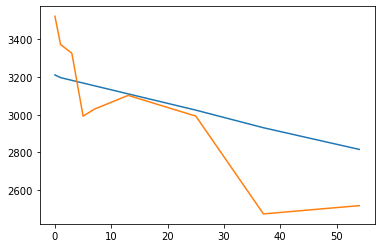

In [35]:
plt.plot(data.weeks, FVC_preds.detach().cpu().numpy())

plt.plot(data.weeks, FVC_true.cpu().numpy())

In [32]:
agg_loss = 0
for FVC, preds in zip(data.fvcs, all_preds):
    coefs = preds[:4]
    log_sigma = preds[4]
#             print(log_sigma.item())

    FVC_preds = (weeks * coefs).sum(dim=1)
    FVC_preds = FVC_preds * FVCs_std + FVCs_mean + 1000 - 200
    FVC_true = torch.tensor(data.fvcs, dtype=dtype)

    agg_loss += LaplaceLossTMP()(FVC_true, FVC_preds, torch.tensor(np.log(70)))
loss = agg_loss / len(data.weeks)

In [33]:
loss

tensor(8.7861, grad_fn=<DivBackward0>)

In [ ]:
log_sigma.item()

In [24]:
from torchsummary import summary

In [26]:
# summary(model.CT_features_extractor[0].net)

In [ ]:
for name, p in model.named_parameters():
    print(f'{name[20:]:50} : {p.data.min().item():15.3e}, {p.data.max().item():15.3e}')

In [13]:
all_preds = model(train_dataset[2])

In [14]:
all_preds

[tensor([-0.0239,  0.0427, -0.0162,  0.0765, -0.0407], grad_fn=<CopyBackwards>),
 tensor([-0.0596,  0.0999,  0.0310,  0.0311, -0.0328], grad_fn=<CopyBackwards>),
 tensor([-0.0534,  0.0610,  0.0263,  0.1096, -0.0509], grad_fn=<CopyBackwards>),
 tensor([-0.0468, -0.0004,  0.0322,  0.0902, -0.0749], grad_fn=<CopyBackwards>),
 tensor([-0.0137,  0.0090,  0.0003,  0.0589, -0.0920], grad_fn=<CopyBackwards>),
 tensor([-0.0302,  0.0220,  0.0029,  0.1146, -0.0387], grad_fn=<CopyBackwards>),
 tensor([-0.0218,  0.0516, -0.0411,  0.0951,  0.0158], grad_fn=<CopyBackwards>),
 tensor([-0.0205,  0.0779, -0.0219,  0.1012, -0.0544], grad_fn=<CopyBackwards>),
 tensor([ 0.0394,  0.0843, -0.0223,  0.0686, -0.0343], grad_fn=<CopyBackwards>)]

In [16]:
data = train_dataset[2]
data_weeks = torch.tensor(data.weeks, dtype=dtype)
weeks = torch.empty(len(data.weeks), 4, dtype=dtype)
weeks[:, 0] = data_weeks ** 3
weeks[:, 1] = data_weeks ** 2
weeks[:, 2] = data_weeks
weeks[:, 3] = 1

# all_preds = model(data)

agg_loss = 0
for week, FVC, preds in zip(data.weeks, data.fvcs, all_preds):
    coefs = preds[:4]
    log_sigma = preds[4]

    FVC_preds = (weeks * coefs).sum(dim=1)
    FVC_true = torch.tensor(data.fvcs, dtype=dtype)

    agg_loss += LaplaceLoss()(FVC_true, FVC_preds, log_sigma)
loss = agg_loss / len(data.weeks)

In [17]:
loss

tensor(4912.0527, grad_fn=<DivBackward0>)

In [18]:
loss.backward()

In [25]:
for name, p in model.named_parameters():
    if p.requires_grad:
        if p.grad is None:
            print(f'Has grad but it is None: {name[20:]:50}')
        else:
            print(f'{name[20:]:50} : {p.grad.data.cpu().min().item():15.3e}, {p.grad.data.cpu().max().item():15.3e}')
    else:
        print(f'No grad: {name[20:]:50}')

RuntimeError: CUDA error: unspecified launch failure

In [12]:
for i in range(len(train_dataset)):
    print(i, train_dataset[i].images.shape)

In [4]:
dataset_all = CTDataset(
    f'{PROCESSED_PATH}/train',
    f'{IMAGE_PATH}/train.csv',
    train=True, test_size=0.0, random_state=42
)

images = [-1000 * (1.0 - dataset_all[i].masks) + dataset_all[i].masks * dataset_all[i].images
          for i in range(len(dataset_all))]

sum_image = 0
sum_sq_image = 0
for image in images:
    sum_image += image.sum()
    sum_sq_image += (image ** 2).sum()

N = np.prod((176., 192., 256., 256.))

mean = sum_image / N

mean

var = sum_sq_image / N + mean ** 2 - 2 * mean * sum_image / N

std = var ** 0.5

mean, std